In [15]:
#############################
# Import libraries
##############################


import os
import glob
import time
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [16]:
print("PyTorch:", torch.__version__)
print("CUDA usada pelo PyTorch:", torch.version.cuda)
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))
    print("Exemplo de tensor no dispositivo:", torch.tensor([1.0, 2.0]).to("cuda"))

PyTorch: 2.7.1+cu128
CUDA usada pelo PyTorch: 12.8
CUDA disponível: True
GPU detectada: NVIDIA GeForce RTX 4060
Exemplo de tensor no dispositivo: tensor([1., 2.], device='cuda:0')


In [17]:
#################################
# Dataset download from Kaggle
#################################

def download_kagglehub_dataset():
    """
    Downloads the dataset from KaggleHub only if it does NOT already exist.
    After download, it searches for the dataset folder (Dataset_hdf or similar)
    and copies it to the current working directory.
    """
    dataset_target = os.path.join(os.getcwd(), "Dataset_hdf")

    # Check if dataset already exists
    if os.path.exists(dataset_target) and len(os.listdir(dataset_target)) > 0:
        print("Dataset already exists. Skipping download.")
        return dataset_target

    dataset_name = "lucasalexandre1997/hvdc-hvac-fault-simulation" # mudar o caminho do dataset no kaggle após subir o zip
    print("Baixando dataset do KaggleHub...")

    cache_path = kagglehub.dataset_download(dataset_name)
    print(f"Download completed.")
    print("Searching for dataset folder in cache...")

    # Procurar a pasta Dataset_hdf (ou similar)
    found_path = None
    for root, dirs, files in os.walk(cache_path):
        for d in dirs:
            if "dataset" in d.lower() or "hdf" in d.lower():
                found_path = os.path.join(root, d)
                break
        if found_path:
            break

    if found_path is None:
        print("Nenhuma pasta chamada 'Dataset_hdf' encontrada, usando raiz do download.")
        found_path = cache_path

    dest_dir = os.path.join(os.getcwd(), "Dataset_hdf")

    # Remove versão antiga, se existir
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    # Copia a pasta detectada para o diretório atual
    shutil.copytree(found_path, dest_dir)

    print(f"Dataset copied to working directory")
    return dataset_target

download_kagglehub_dataset()
data_dir = download_kagglehub_dataset() 
file_pattern = "*.h5"

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.


In [18]:
###########################
# User config
###########################
fault_time = 6.0                 # seconds
pre_window = 0.5                 # seconds before fault
post_window = 0.5                # seconds after fault
dt = 50e-6                       # 50 microseconds = sampling step
sample_rate = 1.0 / dt
window_len = int(round((pre_window + post_window) * sample_rate))
channels = ["Vcc_ret_pos_trace_1", "Vcc_ret_neg_trace_1", "Vcc_inv_pos_trace_1", "Vcc_inv_neg_trace_1",
            "Icc_ret_pos_trace_1", "Icc_ret_neg_trace_1", "Icc_inv_pos_trace_1", "Icc_inv_neg_trace_1",
            "Vac_506_trace_1", "Vac_506_trace_2", "Vac_506_trace_3",
            "Iac_506_trace_1", "Iac_506_trace_2", "Iac_506_trace_3",
            "Vac_550_trace_1", "Vac_550_trace_2", "Vac_550_trace_3",
            "Iac_550_trace_1", "Iac_550_trace_2", "Iac_550_trace_3"]       # electrical signals measured E - voltage/ I - Current
seed = 42
batch_size = 32                   # reduce if GPU OOM, increase if plenty mem
num_epochs = 100
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
random_state = seed

Usando dispositivo: cuda


In [19]:
########################
# Class definitions
########################

class_list = ['NF', 'A-G', 'B-G', 'C-G', 'A-B', 'B-C', 'C-A', 'AB-G', 'BC-G', 'CA-G', 'ABC-G', 'DC+', 'DC-']

def infer_label_from_filename(fname):
    base = os.path.basename(fname).upper()

    # --- No fault ---
    if "NF" in base:
        return "NF"

    # --- DC faults ---
    if "DCPOS" in base or "DC_POS" in base:
        return "DC+"
    if "DCNEG" in base or "DC_NEG" in base:
        return "DC-"

    # --- 3-phase ground ---
    if "ABC-G" in base or "ABCG" in base:
        return "ABC-G"

    # --- 2-phase ground ---
    if ("AB-G" in base) or ("ABG" in base and "ABCG" not in base):
        return "AB-G"
    if ("BC-G" in base) or ("BCG" in base and "ABCG" not in base):
        return "BC-G"
    if ("CA-G" in base) or ("CAG" in base and "ABCG" not in base):
        return "CA-G"

    # --- 2-phase ---
    if ("A-B" in base) or ("AB" in base and "ABG" not in base and "ABCG" not in base):
        return "A-B"
    if ("B-C" in base) or ("BC" in base and "BCG" not in base and "ABCG" not in base):
        return "B-C"
    if ("C-A" in base) or ("CA" in base and "CAG" not in base and "ABCG" not in base):
        return "C-A"

    # --- 1-phase ground ---
    if ("A-G" in base) or ("AG" in base and "ABG" not in base and "CAG" not in base):
        return "A-G"
    if ("B-G" in base) or ("BG" in base and "ABG" not in base and "BCG" not in base):
        return "B-G"
    if ("C-G" in base) or ("CG" in base and "CAG" not in base and "BCG" not in base):
        return "C-G"

    return None


In [20]:
################################
# Pre-processing functions
################################

def cut_window(df, fault_time, pre_window, post_window, dt, channels):
    """
    Extracts a time window around the fault instant.
    Returns an array of shape (C, L).
    """
    center_idx = int(round(fault_time / dt))
    pre_idx = int(pre_window / dt)
    post_idx = int(post_window / dt)

    start_idx = center_idx - pre_idx
    end_idx = center_idx + post_idx

    if start_idx < 0 or end_idx > len(df):
        return None

    window_df = df.iloc[start_idx:end_idx]
    arr = np.stack([window_df[ch].to_numpy() for ch in channels], axis=0).astype(np.float32)
    return arr


def normalize_global(arr, global_mean, global_std, channels):
    #print("normalize arr shape:", arr.shape)
    #print("len channels:", len(channels))
    assert arr.ndim == 2, f"ARR NÃO É 2D — shape {arr.shape}"
    assert arr.shape[0] == len(channels), f"CANAL DESALINHADO — arr tem {arr.shape[0]} canais, mas deveria ter {len(channels)}"
    for i, ch in enumerate(channels):
        arr[i] = (arr[i] - global_mean[ch]) / (global_std[ch] + 1e-9)
    return arr


In [21]:
##############################
# Global normalization stats
##############################

def compute_global_stats(data_dir, file_pattern):
    
    files = sorted(glob.glob(os.path.join(data_dir, file_pattern)))

    sums = {ch: 0.0 for ch in channels}
    sq_sums = {ch: 0.0 for ch in channels}
    counts = {ch: 0 for ch in channels}

    for f in tqdm(files, desc="Computing global stats"):
        try:
            df = pd.read_hdf(f)
        except:
            continue

        if not all(c in df.columns for c in ['Time'] + channels):
            continue

        arr = cut_window(df, fault_time, pre_window, post_window, dt, channels)
        
        if arr is None:
            continue

        # arr shape = (C,L)
        for i, ch in enumerate(channels):
            vals = arr[i]
            sums[ch] += vals.sum()
            sq_sums[ch] += (vals * vals).sum()
            counts[ch] += len(vals)

    global_mean = {}
    global_std = {}

    for ch in channels:
        mean = sums[ch] / counts[ch]
        var = sq_sums[ch] / counts[ch] - mean * mean
        std = np.sqrt(max(var, 1e-12))
        global_mean[ch] = mean
        global_std[ch] = std

    return global_mean, global_std


In [22]:
##############################
# Load and process files
##############################

def load_all_files(data_dir, file_pattern, global_mean, global_std):
    files = sorted(glob.glob(os.path.join(data_dir, file_pattern)))
    X_list = []
    y_list = []
    filenames_used = []

    warnings = []  # <-- guarda avisos para mostrar depois

    for f in tqdm(files, desc="Loading normalized files", ncols=100, leave=True):
        try:
            df = pd.read_hdf(f)
        except Exception as e:
            warnings.append(f"[WARN] Cannot read {f}: {e}")
            continue

        # Check columns
        if not all(c in df.columns for c in ['Time'] + channels):
            warnings.append(f"[WARN] File {f} missing required columns. Skipping.")
            continue

        # Extract window
        arr = cut_window(df, fault_time, pre_window, post_window, dt, channels)
        if arr is None:
            warnings.append(f"[WARN] Window out of bounds for {os.path.basename(f)}. Skipping.")
            continue

        # Normalize globally
        arr = normalize_global(arr, global_mean, global_std, channels)

        # Label
        label = infer_label_from_filename(f)
        if label not in class_list:
            warnings.append(f"[WARN] Invalid label for {os.path.basename(f)}. Skipping.")
            continue

        X_list.append(arr)                     # (C, L)
        y_list.append(class_list.index(label))
        filenames_used.append(os.path.basename(f))

    # Agora sim, imprime os WARNINGS:
    if warnings:
        print("\nWarnings encountered:")
        for w in warnings:
            print(" ", w)

    if len(X_list) == 0:
        raise RuntimeError("No valid files. Check dataset.")

    # Stack all samples
    X = np.stack(X_list, axis=0)   # (N, C, L)
    y = np.array(y_list, dtype=np.int64)

    print(f"\nLoaded {len(X)} samples.")
    print("Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  {class_list[u]}: {c}")

    return X, y, filenames_used


In [23]:
#####################
# Pytorch Dataset
#####################

class SeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Cada timestep tem 20000 pontos → tratamos como 1 canal
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=4, padding=3),  # 20000 → 5000
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Conv1d(16, 32, kernel_size=7, stride=4, padding=3), # 5000 → 1250
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )

        # Agora cada timestep vira 250×64 ≈ 16000 → 256 aprendido
        self.reduce = nn.Linear(32 * 1250, 256)

        # LSTM
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        # x: [batch, 20, 20000]

        batch, seq, samples = x.shape
        x = x.reshape(batch * seq, 1, samples)   # vira 20 "imagens" para a CNN

        x = self.cnn(x)                          # saída: [batch*seq, 64, 250]

        x = x.reshape(batch * seq, -1)           # flatten
        x = self.reduce(x)                       # [batch*seq, 256]

        x = x.reshape(batch, seq, 256)           # volta para timestemps

        out, (h, c) = self.lstm(x)

        return self.fc(h[-1])


In [25]:
###################################
# Training/ evaluation utilities
###################################

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device).float(); yb = yb.to(device).long()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    preds_all = []
    y_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float(); yb = yb.to(device).long()
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            preds_all.append(preds.cpu().numpy())
            y_all.append(yb.cpu().numpy())
    if len(preds_all) > 0:
        preds_all = np.concatenate(preds_all)
        y_all = np.concatenate(y_all)
    else:
        preds_all = np.array([])
        y_all = np.array([])
    return running_loss / total, correct / total, preds_all, y_all

In [26]:
###################
# Main pipeline
###################

def main():

    # ---------------------------
    # Compute global stats
    # ---------------------------
    if compute_global_stats:
        print("Computing global normalization statistics...")
        global_mean, global_std = compute_global_stats(data_dir, file_pattern)
    else:
        global_mean, global_std = None, None

    # ---------------------------
    # Load all normalized samples
    # ---------------------------
    print("Loading data with global normalization...")
    X, y, filenames = load_all_files(data_dir, file_pattern, global_mean, global_std)

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=random_state)

    # ---------------------------
    # Build datasets
    # ---------------------------
    train_ds = SeriesDataset(X_train, y_train)
    val_ds = SeriesDataset(X_val, y_val)
    test_ds = SeriesDataset(X_test, y_test)

    # ---------------------------
    # Build dataloaders
    # ---------------------------
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Print final summary
    print("\nDataset sizes → Train:", len(train_ds),
          "Val:", len(val_ds),
          "Test:", len(test_ds))  

    model = CNN_LSTM(num_classes=len(class_list)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")

        # save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    # load best and evaluate test
    model.load_state_dict(torch.load("best_model.pth"))
    test_loss, test_acc, preds, y_true = eval_epoch(model, test_loader, criterion)
    print(f"\nTest loss {test_loss:.4f} acc {test_acc:.4f}")

    return history, preds, y_true


In [27]:
history, preds, y_true = main()

Computing global normalization statistics...


Computing global stats: 100%|██████████| 1165/1165 [07:28<00:00,  2.60it/s]


Loading data with global normalization...


Loading normalized files: 100%|█████████████████████████████████| 1165/1165 [07:24<00:00,  2.62it/s]



Loaded 1165 samples.
Class distribution:
  NF: 85
  A-G: 90
  B-G: 90
  C-G: 90
  A-B: 90
  B-C: 90
  C-A: 90
  AB-G: 90
  BC-G: 90
  CA-G: 90
  ABC-G: 90
  DC+: 90
  DC-: 90

Dataset sizes → Train: 815 Val: 175 Test: 175
Epoch 1/100 | Train loss 2.4981 acc 0.1546 | Val loss 2.4362 acc 0.2629
Epoch 2/100 | Train loss 2.3655 acc 0.2442 | Val loss 2.3462 acc 0.2743
Epoch 3/100 | Train loss 2.2888 acc 0.2896 | Val loss 2.2765 acc 0.2971
Epoch 4/100 | Train loss 2.2378 acc 0.3227 | Val loss 2.2173 acc 0.4000
Epoch 5/100 | Train loss 2.1586 acc 0.3730 | Val loss 2.1553 acc 0.3486
Epoch 6/100 | Train loss 2.0912 acc 0.4147 | Val loss 2.0954 acc 0.3829
Epoch 7/100 | Train loss 2.0364 acc 0.4123 | Val loss 2.0609 acc 0.3829
Epoch 8/100 | Train loss 1.9624 acc 0.4356 | Val loss 1.9535 acc 0.4286
Epoch 9/100 | Train loss 1.8988 acc 0.4847 | Val loss 1.9294 acc 0.4629
Epoch 10/100 | Train loss 1.8049 acc 0.5546 | Val loss 1.8427 acc 0.4629
Epoch 11/100 | Train loss 1.7255 acc 0.5730 | Val loss 1

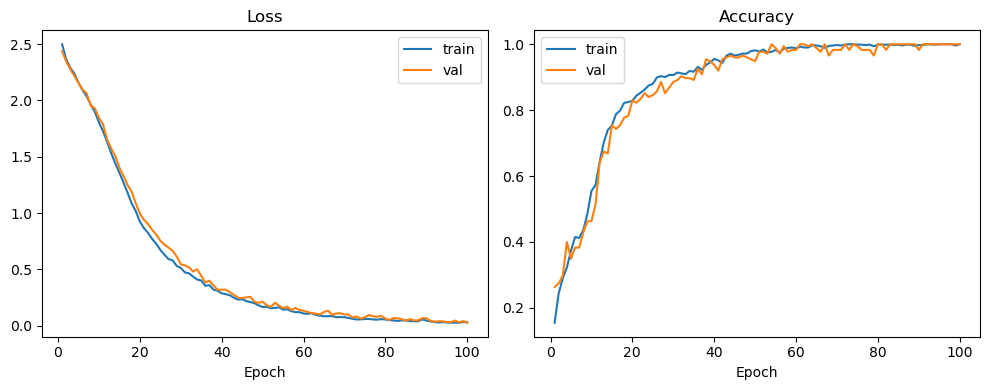

In [28]:
################################################
# Plot Train and validation loss and accuracy
################################################

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='train')
plt.plot(epochs, history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='train')
plt.plot(epochs, history['val_acc'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('CNN_LSTM_training_curves.png', dpi=200)
plt.show()

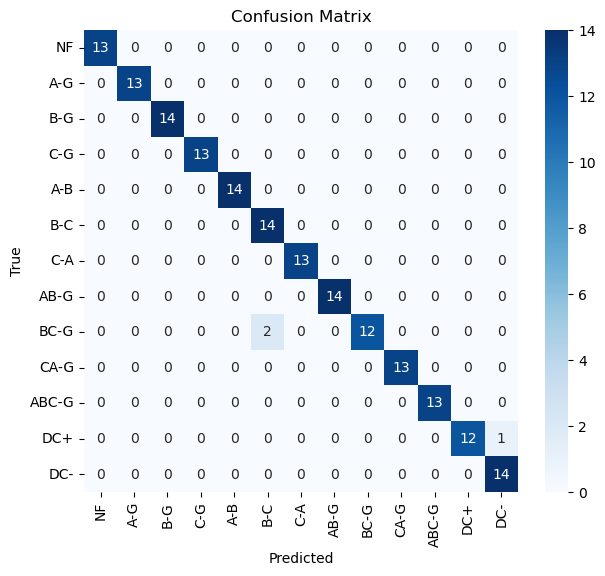

In [29]:
##########################
# Plot confusion matrix
##########################

if preds.size == 0:
    print("No predictions on test set to build confusion matrix.")

cm = confusion_matrix(y_true, preds, labels=range(len(class_list)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_list, yticklabels=class_list, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('CNN_LSTM_confusion_matrix.png', dpi=200)
plt.show()

In [30]:
###################################################
# Compute metrics per class from confusion matrix
###################################################

cm = cm.astype(np.float64)   # ensure float

num_classes = cm.shape[0]
metrics_acc = []
metrics_sens = []
metrics_spec = []

for i in range(num_classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    metrics_acc.append(accuracy * 100)
    metrics_sens.append(sensitivity * 100)
    metrics_spec.append(specificity * 100)


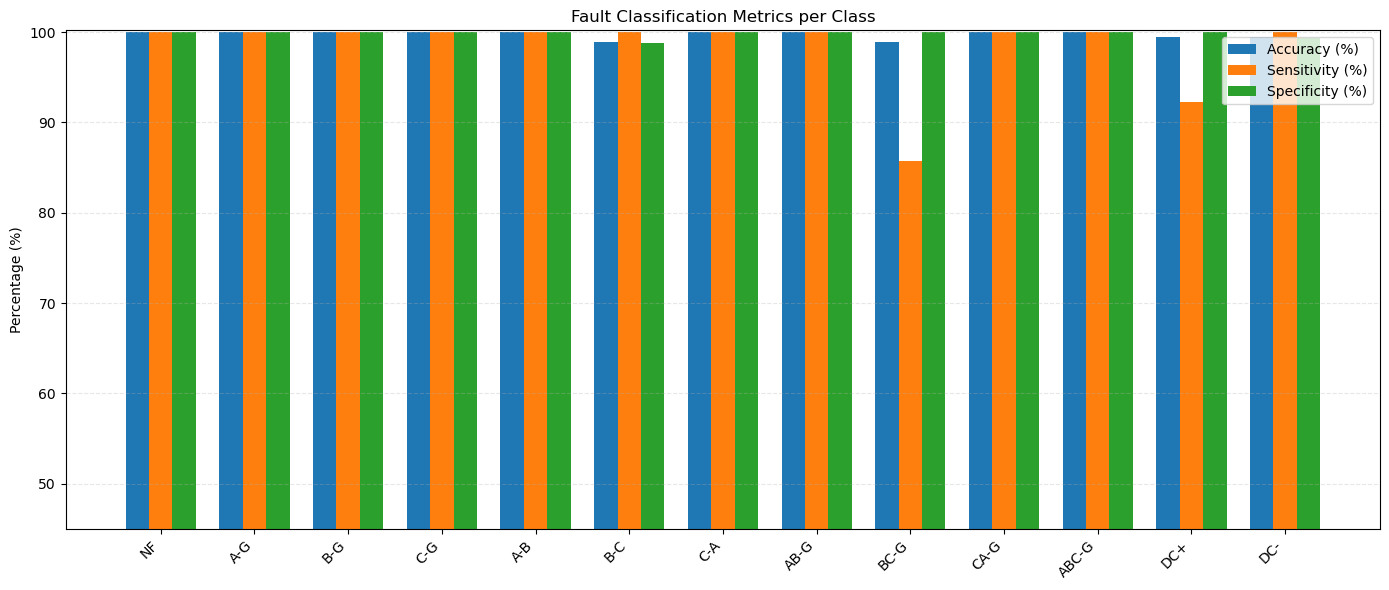

In [31]:
##########################################
# Plot bar chart (Accuracy / Sensitivity / Specificity)
##########################################

x = np.arange(num_classes)
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, metrics_acc, width, label="Accuracy (%)")
plt.bar(x, metrics_sens, width, label="Sensitivity (%)")
plt.bar(x + width, metrics_spec, width, label="Specificity (%)")

plt.xticks(x, class_list, rotation=45, ha='right')
plt.ylabel("Percentage (%)")
plt.title("Fault Classification Metrics per Class")
plt.ylim(45, 100.2)   # mesmo estilo do seu gráfico de referência
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("CNN_LSTM_metrics_per_class.png", dpi=200)
plt.show()

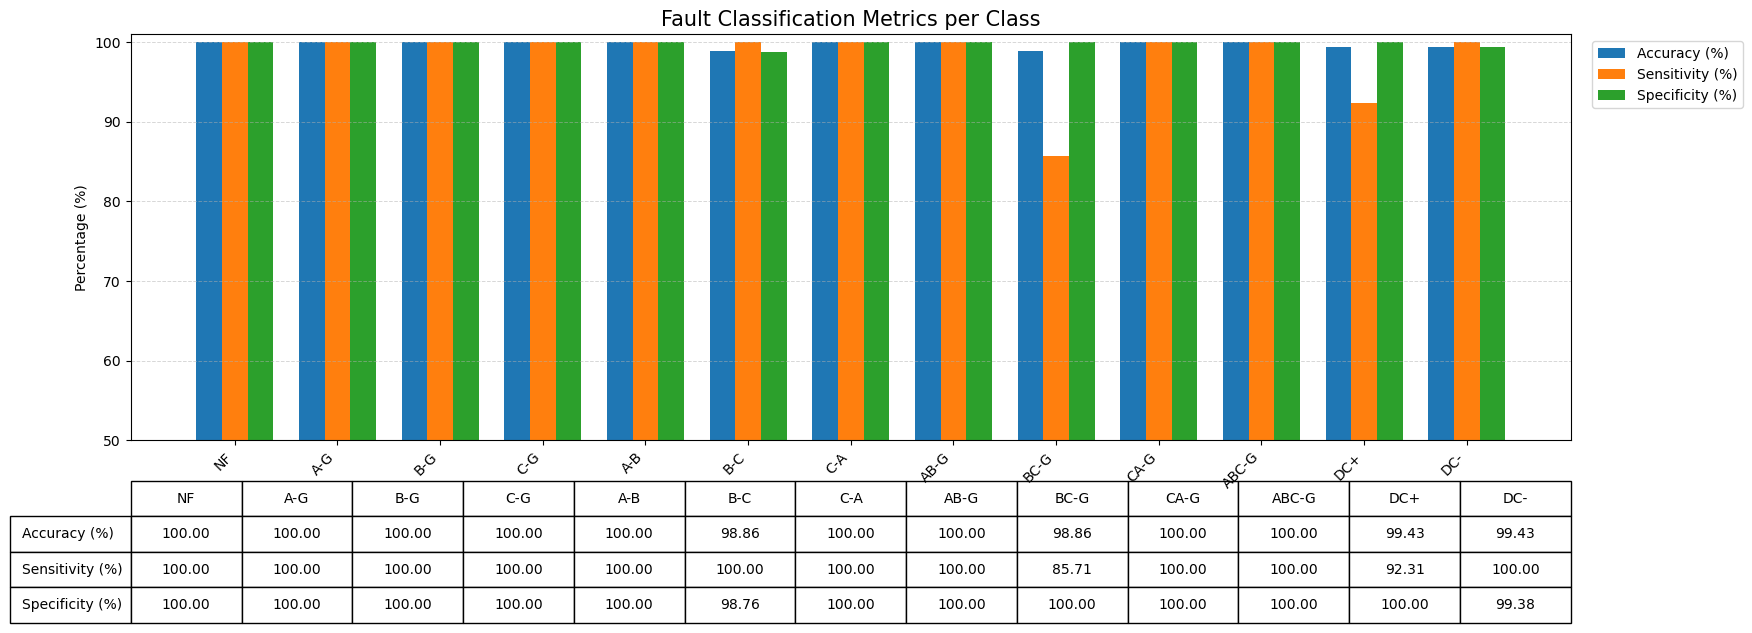

In [32]:
num_classes = len(class_list)
x = np.arange(num_classes)
width = 0.25

fig, ax = plt.subplots(figsize=(16, 7))

# ================================
#       GRÁFICO DE BARRAS
# ================================
ax.bar(x - width, metrics_acc, width, label="Accuracy (%)")
ax.bar(x,         metrics_sens, width, label="Sensitivity (%)")
ax.bar(x + width, metrics_spec, width, label="Specificity (%)")

ax.set_xticks(x)
ax.set_xticklabels(class_list, rotation=45, ha='right')

ax.set_ylabel("Percentage (%)")
ax.set_ylim(50, 101)

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.5)
ax.set_title("Fault Classification Metrics per Class", fontsize=15)

ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))

# ================================
#      TABELA (ALINHADA)
# ================================

row_labels = ["Accuracy (%)", "Sensitivity (%)", "Specificity (%)"]

cell_data = [
    [f"{v:.2f}" for v in metrics_acc],
    [f"{v:.2f}" for v in metrics_sens],
    [f"{v:.2f}" for v in metrics_spec],
]

# Criar a tabela manualmente alinhando usando bbox
table = plt.table(
    cellText=cell_data,
    rowLabels=row_labels,
    colLabels=class_list,
    cellLoc='center',
    loc='bottom',
    bbox=[0.0, -0.45, 1.0, 0.35]  
    # [esquerda, baixo, largura, altura]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.25, 1.25)

# Ajustar espaçamento geral
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.32, top=0.9)

plt.savefig("LSTM_metrics_table_aligned.png", dpi=200)
plt.show()

In [33]:
###################
# metrics table
###################

df_metrics = pd.DataFrame({
    "Class": class_list,
    "Accuracy (%)": metrics_acc,
    "Sensitivity (%)": metrics_sens,
    "Specificity (%)": metrics_spec
})
pd.options.display.float_format = "{:.3f}".format
print(df_metrics)
df_metrics.to_csv("CNN_LSTM_metrics_per_class.csv", index=False)

    Class  Accuracy (%)  Sensitivity (%)  Specificity (%)
0      NF       100.000          100.000          100.000
1     A-G       100.000          100.000          100.000
2     B-G       100.000          100.000          100.000
3     C-G       100.000          100.000          100.000
4     A-B       100.000          100.000          100.000
5     B-C        98.857          100.000           98.758
6     C-A       100.000          100.000          100.000
7    AB-G       100.000          100.000          100.000
8    BC-G        98.857           85.714          100.000
9    CA-G       100.000          100.000          100.000
10  ABC-G       100.000          100.000          100.000
11    DC+        99.429           92.308          100.000
12    DC-        99.429          100.000           99.379


In [34]:
print("Acurácia geral:", accuracy_score(y_true, preds))

print("Sensibilidade média:", recall_score(y_true, preds, average='macro'))

Acurácia geral: 0.9828571428571429
Sensibilidade média: 0.9830938292476754


In [35]:
def specificity_multiclass(cm):
    num_classes = cm.shape[0]
    spec_per_class = []

    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        # Specificity for class i
        spec_i = TN / (TN + FP) if (TN + FP) > 0 else 0
        spec_per_class.append(spec_i)

    # Macro average specificity (the correct global metric)
    spec_macro = np.mean(spec_per_class)

    return spec_per_class, spec_macro

spec_per_class, spec_macro = specificity_multiclass(cm)

print("Specificidade por classe:")
for i, s in enumerate(spec_per_class):
    print(f"Classe {i}: {s:.4f}")

print("\nSpecificidade global (macro):", spec_macro)

Specificidade por classe:
Classe 0: 1.0000
Classe 1: 1.0000
Classe 2: 1.0000
Classe 3: 1.0000
Classe 4: 1.0000
Classe 5: 0.9876
Classe 6: 1.0000
Classe 7: 1.0000
Classe 8: 1.0000
Classe 9: 1.0000
Classe 10: 1.0000
Classe 11: 1.0000
Classe 12: 0.9938

Specificidade global (macro): 0.9985666507405638


In [36]:
##########################
# Uncertanity calculus
##########################


def wilson_interval(p, n, z=1.96):
    if n == 0:
        return (0, 0)

    denominator = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denominator
    margin = z * sqrt((p*(1-p))/n + (z**2)/(4*n**2)) / denominator

    return center - margin, center + margin


# Example with your confusion-matrix derived numbers:
def metric_ci(TP, FN, FP, TN, z=1.96):

    # Accuracy
    n_acc = TP + FN + FP + TN
    p_acc = (TP + TN) / n_acc
    ci_acc = wilson_interval(p_acc, n_acc, z)

    # Sensitivity
    n_sens = TP + FN
    p_sens = TP / n_sens if n_sens > 0 else 0
    ci_sens = wilson_interval(p_sens, n_sens, z)

    # Specificity
    n_spec = TN + FP
    p_spec = TN / n_spec if n_spec > 0 else 0
    ci_spec = wilson_interval(p_spec, n_spec, z)

    return ci_acc, ci_sens, ci_spec


# Compute GLOBAL TP FP FN TN from confusion matrix
TP = np.trace(cm)
FN = cm.sum(axis=1) - np.diag(cm)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (TP + FN + FP)

TP_global = TP
FN_global = FN.sum()
FP_global = FP.sum()
TN_global = TN.sum()

ci_acc, ci_sens, ci_spec = metric_ci(TP_global, FN_global, FP_global, TN_global)

print("Accuracy CI:", ci_acc)
print("Sensitivity CI:", ci_sens)
print("Specificity CI:", ci_spec)

Accuracy CI: (0.9393599102976388, 0.9869039045315192)
Sensitivity CI: (0.9508171515694163, 0.9941531461689176)
Specificity CI: (0.7817298972308114, 0.9712519107287082)
